 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/page%20speed%20analysis%20example.ipynb#ページ速度の分析" data-toc-modified-id="ページ速度の分析-1">ページ速度の分析</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/page%20speed%20analysis%20example.ipynb#BigQuery-からデータを取得する" data-toc-modified-id="BigQuery-からデータを取得する-1.1">BigQuery からデータを取得する</a></span></li><li><span><a href="http://localhost:8888/notebooks/page%20speed%20analysis%20example.ipynb#データの内容の確認" data-toc-modified-id="データの内容の確認-1.2">データの内容の確認</a></span></li><li><span><a href="http://localhost:8888/notebooks/page%20speed%20analysis%20example.ipynb#可視化" data-toc-modified-id="可視化-1.3">可視化</a></span></li><li><span><a href="http://localhost:8888/notebooks/page%20speed%20analysis%20example.ipynb#さらなる定量評価と改善すべきページの洗い出し" data-toc-modified-id="さらなる定量評価と改善すべきページの洗い出し-1.4">さらなる定量評価と改善すべきページの洗い出し</a></span></li></ul></li></ul></div>

# ページ速度の分析

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## BigQuery からデータを取得する
SQL の定義（  `__PROJECT__, __DATASET__, __START_DATE__, __END_DATE__` は自分の環境にあわせて適宜変更する ）

In [3]:
sql = '''
WITH base AS (
  SELECT
    fullVisitorId
    , CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS sessionId
    , h.hitNumber AS hitNumber
    , REGEXP_REPLACE(h.page.pagePath, r'\?[a-zA-Z0-9]+=.*', '') AS page
    , h.type AS hitType
    , h.isExit AS isExit
    , h.latencyTracking.pageLoadSample AS pageLoadSample
    , h.latencyTracking.pageLoadTime AS pageLoadTime
  FROM
    `__PROJECT__.__DATASET__.ga_sessions_20*`
    , UNNEST(hits) AS h
  WHERE
    _TABLE_SUFFIX BETWEEN '__START_DATE__' AND '__END_DATE__'
)
, page_speed AS (
  SELECT
    fullVisitorId
    , sessionId
    , hitNumber
    , hitType
    , page
    , pageLoadTime
  FROM
    base
  WHERE
    pageLoadSample = 1
)
, pages AS (
  SELECT
    fullVisitorId
    , sessionId
    , hitNumber
    , page
    , isExit
    , hitType
  FROM
    base
  WHERE
    hitType = 'PAGE'
)

SELECT
  t1.fullVisitorId
  , t1.sessionId
  , t2.hitNumber AS hitNumber
  , t1.page
  , t1.pageLoadTime
  , CAST(IF(t2.isExit IS TRUE, 1, 0) AS INT64) AS isExit
FROM
  page_speed AS t1
JOIN (
  SELECT 
    sessionId
    , hitNumber
    , page
    , isExit
    , hitType
  FROM
    pages
) AS t2
ON 
  t1.sessionId = t2.sessionId 
  AND t1.page = t2.page
  AND t1.hitNumber = t2.hitNumber+1
ORDER BY
  fullVisitorId
  , sessionId ASC
  , hitNumber ASC
'''

Google Cloud の Project ID を設定する（自分の環境に合わせて適宜変更する）

In [4]:
project_id = '__PROJECT__'

pandas の read_gbq メソッドを使ってデータを取得する

In [5]:
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Processed: 9.2 MB

Retrieving results...
  Got page: 1; 100% done. Elapsed 11.78 s.
Got 871 rows.

Total time taken 11.8 s.
Finished at 2018-01-15 06:03:25.


## データの内容の確認
とりあえず df.head() と df.describe() で概要をつかむ

In [6]:
df.head()

,fullVisitorId,sessionId,hitNumber,page,pageLoadTime,isExit
0,1001466708552294901,10014667085522949011505183639,1,/2012/08/google-nri.html,3612,0
1,1001466708552294901,10014667085522949011505183639,9,/2012/08/google-nri.html,396,1
2,1023676757520811215,10236767575208112151490683089,1,/2013/01/lixil-google.html,7347,1
3,1039176933731003273,10391769337310032731506864007,1,/2016/05/firebase-analytics.html,4534,0
4,1039176933731003273,10391769337310032731506864007,3,/2017/05/firebase-analytics.html,3198,1


In [7]:
df.describe()

,hitNumber,pageLoadTime,isExit
count,871.000000,871.000000,871.000000
mean,1.815155,5070.510907,0.842710
std,2.813195,7578.132540,0.364284
min,1.000000,169.000000,0.000000
25%,1.000000,1733.500000,1.000000
50%,1.000000,2886.000000,1.000000
75%,1.000000,5491.000000,1.000000
max,39.000000,113955.000000,1.000000


離脱している群（ isExit が 1 のもの ）と離脱していない群を比較する

In [8]:
df[df.isExit==1].describe()

,hitNumber,pageLoadTime,isExit
count,734.000000,734.000000,734.0
mean,1.630790,5295.442779,1.0
std,2.463082,8058.721464,0.0
min,1.000000,228.000000,1.0
25%,1.000000,1802.250000,1.0
50%,1.000000,2917.500000,1.0
75%,1.000000,5755.750000,1.0
max,39.000000,113955.000000,1.0


In [9]:
df[df.isExit==0].describe()

,hitNumber,pageLoadTime,isExit
count,137.000000,137.000000,137.0
mean,2.802920,3865.401460,0.0
std,4.094184,3951.105634,0.0
min,1.000000,169.000000,0.0
25%,1.000000,1582.000000,0.0
50%,1.000000,2746.000000,0.0
75%,3.000000,4534.000000,0.0
max,28.000000,31838.000000,0.0


離脱してる方が
- hit number は 1.2 ほど小さい
- pageLoadTime は 平均で 1.43 秒長い（が、分散が倍近い）  

これらの違いを可視化して確認してみる。

## 可視化
とりあえず離脱群と非離脱群の比較を Boxplot で行う

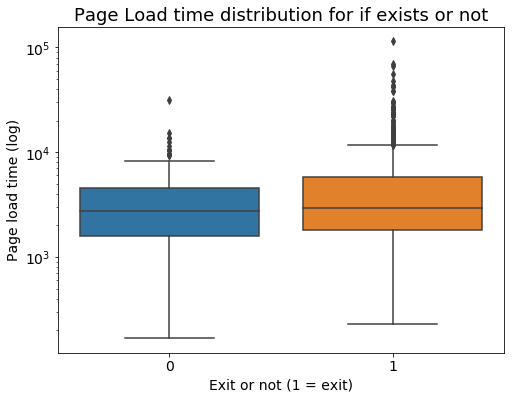

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax = sns.boxplot(x='isExit', y='pageLoadTime', data=df, dodge=True)
ax.set(yscale='log')
ax.set_title('Page Load time distribution for if exists or not', fontsize=18)
ax.set_xlabel('Exit or not (1 = exit)', fontsize=14)
ax.set_ylabel('Page load time (log)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

離脱群と非離脱群の違いが小さくこれだけだとわかりにくいので、もう少しブレイクダウンする。まず hit number の傾向を把握する。

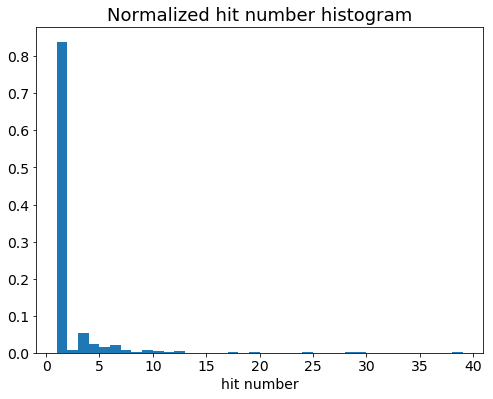

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.set_title('Normalized hit number histogram', fontsize=18)
ax.hist(df.hitNumber, bins=38, normed=True)
ax.set_xlabel('hit number', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

おおよそ 11 ~ 12 あたりまでで 90 % 占めてそう。  
hitNumber < 15 で Botplot 描いてみる

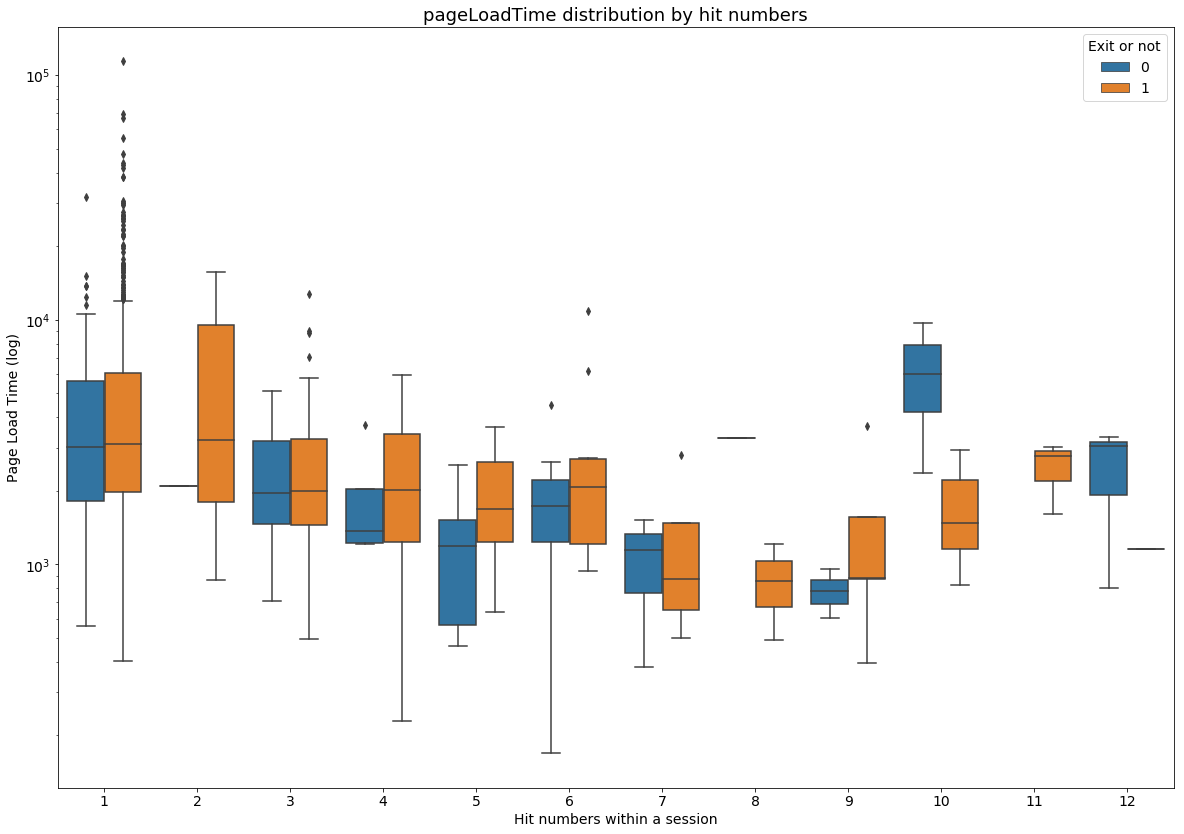

In [12]:
data = df[df.hitNumber < 15]
fig = plt.figure(figsize=(20, 14))
ax = sns.boxplot(x='hitNumber', y='pageLoadTime', hue='isExit',
               data=data,
               dodge=True)
ax.set_title('pageLoadTime distribution by hit numbers', fontsize=18)
ax.set(yscale='log')
ax.set_ylabel('Page Load Time (log)', fontsize=14)
ax.set_xlabel('Hit numbers within a session', fontsize=14)
ax.legend(fontsize=14).set_title('Exit or not', prop={'size': 14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Hit number = 6 までは、概ね離脱の有無と pageLoadTime に正の相関ありそう（ 離脱群の方が pageLoadTime 長そう ）。  
それ以降はまちまち。

## さらなる定量評価と改善すべきページの洗い出し
page ✕ 離脱の有無 ごとに pageLoadTime の中央値と標準偏差を計算する。

In [13]:
data = df[['page', 'isExit', 'pageLoadTime']].groupby(
    ['page', 'isExit'], as_index=False).agg({'pageLoadTime': ['median', 'std']})
data.columns = ['page', 'isExit', 'median_pageLoadTime', 'std_pageLoadTime']

In [14]:
data.head()

,page,isExit,median_pageLoadTime,std_pageLoadTime
0,/,0,3940.0,5139.768735
1,/,1,4850.5,9729.451438
2,/2007/07/blog-post_23.html,1,3699.0,1426.941484
3,/2007/09/how-to-track-email-campaigns.html,1,4328.0,NaN
4,/2007/10/how-to-restore-garbled-japanese.html,1,3300.5,1685.741934


欠損値を埋めるために、  
- 元データ（ df ）から、ページの URL のユニーク値を取得
- カラム isExit の欠損値は 1、0 で埋める
- pageLoadTime の中央値・標準偏差の欠損値は、それぞれの平均で埋める

In [15]:
pages = pd.DataFrame(df['page'].unique(), columns=['page'])

In [16]:
data_exit = data[data.isExit == 1]
data_non_exit = data[data.isExit==0]

data_exit = pd.merge(pages, data_exit, on='page', how='left')
data_exit['isExit'] = data_exit.isExit.fillna(1)
data_exit['median_pageLoadTime'] = data_exit.median_pageLoadTime.fillna(data_exit.median_pageLoadTime.mean())
data_exit['std_pageLoadTime'] = data_exit.std_pageLoadTime.fillna(data_exit.std_pageLoadTime.mean())

data_non_exit = pd.merge(pages, data_non_exit, on='page', how='left')
data_non_exit['isExit'] = data_non_exit.isExit.fillna(0)
data_non_exit['median_pageLoadTime'] = data_non_exit.median_pageLoadTime.fillna(data_non_exit.median_pageLoadTime.mean())
data_non_exit['std_pageLoadTime'] = data_non_exit.std_pageLoadTime.fillna(data_non_exit.std_pageLoadTime.mean())

In [17]:
page_data = pd.concat([data_exit, data_non_exit])

ページ・離脱の有無・pageLoadTime の平均でソート

In [18]:
page_data.sort_values(by=['page', 'isExit', 'median_pageLoadTime'], ascending=['True', 'True', 'False']).head(10)

,page,isExit,median_pageLoadTime,std_pageLoadTime
5,/,0.0,3940.00,5139.768735
5,/,1.0,4850.50,9729.451438
86,/2007/07/blog-post_23.html,0.0,2853.11,1348.467733
86,/2007/07/blog-post_23.html,1.0,3699.00,1426.941484
91,/2007/09/how-to-track-email-campaigns.html,0.0,2853.11,1348.467733
91,/2007/09/how-to-track-email-campaigns.html,1.0,4328.00,2179.203837
41,/2007/10/how-to-restore-garbled-japanese.html,0.0,2853.11,1348.467733
41,/2007/10/how-to-restore-garbled-japanese.html,1.0,3300.50,1685.741934
124,/2007/12/how-to-set-up-goal.htm,0.0,2853.11,1348.467733
124,/2007/12/how-to-set-up-goal.htm,1.0,2176.00,2179.203837


離脱群と非離脱群で、中央値 pageLoadTime の差が大きいものとそうでないものがある。差が大きい方が離脱に影響している可能性高そうなので、離脱群と非離脱群で pageLoadTime の中央値と標準偏差の差分を取り、page でユニークなテーブルを作成する。

In [19]:
pivoted = page_data.pivot(columns='isExit', index='page')
pivoted.columns = [
    'nonexit_median_pageLoadTime', 'exit_median_pageLoadTime',
    'nonexit_std_pageLoadTime', 'exit_std_pageLoadTime']
pivoted = pivoted.reset_index()
pivoted['diff_median_pageLoadTime'] = pivoted.exit_median_pageLoadTime - pivoted.nonexit_median_pageLoadTime
pivoted['diff_std_pageLoadTime'] = pivoted.exit_std_pageLoadTime - pivoted.nonexit_std_pageLoadTime

離脱群と非離脱群で pageLoadTime の中央値の差が大きく、標準偏差の差が小さいものでソート  
- 中央値の差が大きくばらつきの違いが小さいものから順にページ速度の改善を検討する。

In [20]:
rankings = pivoted.sort_values(by=['diff_median_pageLoadTime', 'diff_std_pageLoadTime'], ascending=[False, True])
rankings[['page', 'diff_median_pageLoadTime', 'diff_std_pageLoadTime']].head(10)

,page,diff_median_pageLoadTime,diff_std_pageLoadTime
116,/2017/11/blog-post.html,12419.89,830.736104
115,/2017/10/google_3.html,7082.00,830.736104
38,/2013/09/google.html,5066.39,5003.472482
100,/2017/05/google-google-360-adwords.html,4703.00,-355.810021
58,/2016/06/blog-post.html,4076.89,830.736104
124,/2018/01/google.html,3045.89,830.736104
99,/2017/05/google-amp.html,2746.00,1683.895813
123,/2017/12/firebase-google.html,2424.89,830.736104
28,/2011/12/club-panasonic-google.html,2353.89,830.736104
107,/2017/10/blog-post.html,2308.00,2439.281633
